In [ ]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [ ]:
import cv2
import easyocr
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import os

# ----------------- PARAMETERS -----------------
BASE_ROI_WIDTH = 300   # Increased base width
BASE_ROI_HEIGHT = 200  # Increased base height
MIN_SCALE = 0.7        # Increased minimum scale to prevent tiny ROIs
MAX_SCALE = 2.5        # Increased maximum scale for larger text
SCALE_STEP = 0.2       # Smaller step for finer control

HORIZONTAL_STEP = 30   # Reduced for finer movement
VERTICAL_STEP = 30     # Reduced for finer movement

NUM_EPISODES = 250     # Increased episodes for better learning
MAX_STEPS = 30         # Increased steps per episode
GAMMA = 0.99           # Increased discount factor for longer-term rewards
EPSILON = 1.0          # Initial exploration probability
EPSILON_MIN = 0.05     # Slightly higher minimum exploration
EPSILON_DECAY = 0.997  # Slower decay for more exploration
LEARNING_RATE = 0.0005 # Reduced learning rate for stability
BATCH_SIZE = 64        # Increased batch size
MEMORY_SIZE = 20000    # Larger replay buffer

TARGET_SIM_THRESHOLD = 0.7  # Lowered threshold for determining target text found
EARLY_STOP_THRESHOLD = 0.8  # Early stopping threshold

# ----------------- GLOBALS -----------------
ocr_cache = {}  # Global cache for OCR results
reader = None   # Global EasyOCR reader

# ----------------- DQN MODEL -----------------
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

# ----------------- EXPERIENCE REPLAY -----------------
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# ----------------- EASYOCR SETUP -----------------
def setup_reader(use_gpu=True):
    print("Initializing EasyOCR reader...")
    return easyocr.Reader(['en'], gpu=use_gpu)

# ----------------- UTILITY FUNCTIONS -----------------
def get_cropped_image(image, roi):
    x, y, w, h = roi
    # Ensure ROI is within image boundaries
    x = max(0, min(x, image.shape[1] - 1))
    y = max(0, min(y, image.shape[0] - 1))
    w = min(w, image.shape[1] - x)
    h = min(h, image.shape[0] - y)
    return image[y:y+h, x:x+w]

def jaccard_similarity_ngrams(text1, text2, n=2):
    if not text1 or not text2:
        return 0.0

    t1 = text1.replace(" ", "").lower()
    t2 = text2.replace(" ", "").lower()

    if len(t1) < n or len(t2) < n:
        n = 1

    ngrams1 = set(t1[i:i+n] for i in range(len(t1)-n+1)) if len(t1) >= n else {t1}
    ngrams2 = set(t2[i:i+n] for i in range(len(t2)-n+1)) if len(t2) >= n else {t2}

    intersection = ngrams1.intersection(ngrams2)
    union = ngrams1.union(ngrams2)
    return len(intersection) / len(union) if union else 0

def estimate_text_size(target_text):
    text_len = len(target_text)
    width_estimate = max(200, min(600, text_len * 25))
    height_estimate = max(100, min(300, width_estimate // 2))
    print(f"Estimated dimensions for '{target_text}': {width_estimate}x{height_estimate}")
    return width_estimate, height_estimate

# ----------------- OCR FUNCTION WITH CACHING -----------------
def ocr_and_text(image, roi, target_text):
    global reader
    if reader is None:
        reader = setup_reader()
    cropped = get_cropped_image(image, roi)
    if cropped.shape[0] < 10 or cropped.shape[1] < 10:
        return "", 0.0
    try:
        results = reader.readtext(cropped)
        if results:
            recognized_text = " ".join([result[1] for result in results])
            sim = jaccard_similarity_ngrams(recognized_text, target_text)
            return recognized_text, sim
        return "", 0.0
    except Exception as e:
        print(f"OCR error: {e}")
        return "", 0.0

def ocr_and_text_with_cache(image, roi, target_text, cache_precision=5):
    # Create a cache key based on rounded ROI values
    key = tuple(round(v, cache_precision) for v in roi)
    if key in ocr_cache:
        return ocr_cache[key]
    result = ocr_and_text(image, roi, target_text)
    ocr_cache[key] = result
    return result

def show_roi(image, roi, title="ROI", similarity=0.0, text=""):
    disp_img = image.copy()
    x, y, w, h = roi
    color = (0, int(255 * similarity), int(255 * (1-similarity)))
    '''
    cv2.rectangle(disp_img, (x, y), (x+w, y+h), color, 3)

    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(disp_img, cv2.COLOR_BGR2RGB))

    plt.title(f"{title} - Similarity: {similarity:.4f}")
    if text:
        plt.figtext(0.5, 0.01, f"Text: '{text}'", ha="center")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    '''
def calculate_reward(similarity, prev_similarity, step, roi_scale):
    reward = similarity
    if similarity > prev_similarity:
        reward += 0.5 * (similarity - prev_similarity)
    step_penalty = 0.01 * (step / MAX_STEPS)
    reward -= step_penalty
    if similarity > 0.8:
        reward += 2.0
    elif similarity > 0.6:
        reward += 0.5
    if roi_scale < MIN_SCALE + SCALE_STEP or roi_scale > MAX_SCALE - SCALE_STEP:
        reward -= 0.2
    return reward

# ----------------- DQN-BASED TRAINING WITH ADAPTIVE ROI -----------------
def train_dqn_agent(image, target_text, model_save_path="dqn_adaptive_ocr_model.pt", num_episodes=NUM_EPISODES):
    global reader
    if reader is None:
        reader = setup_reader()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on: {device}")
    h_img, w_img = image.shape[:2]
    estimated_width, estimated_height = estimate_text_size(target_text)
    print(f"Estimated ROI dimensions for '{target_text}': {estimated_width}x{estimated_height}")
    base_roi_width = estimated_width
    base_roi_height = estimated_height
    num_actions = 12
    input_dim = 5

    policy_net = DQN(input_dim, num_actions).to(device)
    target_net = DQN(input_dim, num_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
    criterion = nn.SmoothL1Loss()
    memory = ReplayMemory(MEMORY_SIZE)

    movement_actions = [
        (-HORIZONTAL_STEP, 0),
        (HORIZONTAL_STEP, 0),
        (0, -VERTICAL_STEP),
        (0, VERTICAL_STEP),
        (-HORIZONTAL_STEP, -VERTICAL_STEP),
        (HORIZONTAL_STEP, -VERTICAL_STEP),
        (-HORIZONTAL_STEP, VERTICAL_STEP),
        (HORIZONTAL_STEP, VERTICAL_STEP)
    ]
    scale_actions = [
        (-SCALE_STEP, 0),
        (SCALE_STEP, 0),
        (0, -SCALE_STEP),
        (0, SCALE_STEP)
    ]

    epsilon = EPSILON
    best_similarity = 0.0
    best_roi = None
    best_scale = (1.0, 1.0)

    all_rewards = []
    all_losses = []

    print("Starting training...")
    for episode in range(num_episodes):
        x = random.randint(w_img//4, 3*w_img//4 - base_roi_width)
        y = random.randint(h_img//4, 3*h_img//4 - base_roi_height)
        width_scale = max(MIN_SCALE, min(MAX_SCALE, 1.0 + random.random() * 0.4))
        height_scale = max(MIN_SCALE, min(MAX_SCALE, 1.0 + random.random() * 0.4))
        prev_reward = 0.0
        state = np.array([x, y, width_scale, prev_reward, 0], dtype=np.float32)
        episode_total_reward = 0.0
        episode_loss_sum = 0.0
        num_loss_updates = 0
        current_similarity = 0.0

        for step in range(MAX_STEPS):
            if random.random() < epsilon:
                action_idx = random.randint(0, num_actions - 1)
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor(state, dtype=torch.float32).to(device).unsqueeze(0)
                    q_values = policy_net(state_tensor)
                    action_idx = q_values.argmax().item()

            if action_idx < 8:
                dx, dy = movement_actions[action_idx]
                new_x = min(max(x + dx, 0), w_img - int(base_roi_width * width_scale))
                new_y = min(max(y + dy, 0), h_img - int(base_roi_height * height_scale))
                new_width_scale = width_scale
                new_height_scale = height_scale
            else:
                new_x, new_y = x, y
                dw_scale, dh_scale = scale_actions[action_idx - 8]
                new_width_scale = max(MIN_SCALE, min(MAX_SCALE, width_scale + dw_scale))
                new_height_scale = max(MIN_SCALE, min(MAX_SCALE, height_scale + dh_scale))
                if new_x + int(base_roi_width * new_width_scale) > w_img:
                    new_x = w_img - int(base_roi_width * new_width_scale)
                if new_y + int(base_roi_height * new_height_scale) > h_img:
                    new_y = h_img - int(base_roi_height * new_height_scale)

            roi_width = int(base_roi_width * new_width_scale)
            roi_height = int(base_roi_height * new_height_scale)
            roi_width = max(100, roi_width)
            roi_height = max(80, roi_height)
            roi = [new_x, new_y, roi_width, roi_height]
            recognized_text, similarity = ocr_and_text_with_cache(image, roi, target_text)
            avg_scale = (new_width_scale + new_height_scale) / 2
            reward = calculate_reward(similarity, current_similarity, step, avg_scale)
            episode_total_reward += reward
            next_state = np.array([new_x, new_y, new_width_scale, reward, step+1], dtype=np.float32)
            done = (step == MAX_STEPS - 1) or (similarity >= EARLY_STOP_THRESHOLD)
            memory.push(state, action_idx, reward, next_state, done)
            state = next_state
            x, y = new_x, new_y
            width_scale, height_scale = new_width_scale, new_height_scale
            current_similarity = similarity

            if similarity > best_similarity:
                best_similarity = similarity
                best_roi = roi
                best_scale = (width_scale, height_scale)
                if episode % 100 == 0:
                    show_roi(image, roi,
                             title=f"Episode {episode}, Step {step} - Scale: {width_scale:.2f}x{height_scale:.2f}",
                             similarity=similarity,
                             text=recognized_text)

            if done and similarity >= EARLY_STOP_THRESHOLD:
                break

            if len(memory) >= BATCH_SIZE:
                batch = memory.sample(BATCH_SIZE)
                states, actions, rewards, next_states, dones = zip(*batch)
                states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
                actions = torch.tensor(np.array(actions), dtype=torch.int64).to(device)
                rewards = torch.tensor(np.array(rewards), dtype=torch.float32).to(device)
                next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(device)
                dones = torch.tensor(np.array(dones), dtype=torch.bool).to(device)
                current_q = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    max_next_q = target_net(next_states).max(1)[0]
                    target_q = rewards + GAMMA * max_next_q * (~dones)
                loss = criterion(current_q, target_q)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
                optimizer.step()
                episode_loss_sum += loss.item()
                num_loss_updates += 1

        if epsilon > EPSILON_MIN:
            epsilon *= EPSILON_DECAY
        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())
        if episode % 200 == 0 and episode > 0:
            torch.save({
                'model_state_dict': policy_net.state_dict(),
                'base_roi_width': base_roi_width,
                'base_roi_height': base_roi_height
            }, model_save_path)
        if episode % 20 == 0:
            avg_loss = episode_loss_sum / max(1, num_loss_updates)
            avg_reward = episode_total_reward / max(1, step+1)
            all_rewards.append(avg_reward)
            all_losses.append(avg_loss)
            print(f"Episode {episode}/{num_episodes} | Reward: {episode_total_reward:.4f} | Avg Reward/Step: {avg_reward:.4f} | Loss: {avg_loss:.6f} | Epsilon: {epsilon:.4f} | Best Scale: {best_scale[0]:.2f}x{best_scale[1]:.2f} | Best Sim: {best_similarity:.4f}")

    torch.save({
        'model_state_dict': policy_net.state_dict(),
        'base_roi_width': base_roi_width,
        'base_roi_height': base_roi_height
    }, model_save_path)
    print(f"Training complete. Best similarity: {best_similarity:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(all_rewards)
    plt.title('Average Reward per Episode')
    plt.xlabel('Episode (x20)')
    plt.ylabel('Reward')
    plt.subplot(1, 2, 2)
    plt.plot(all_losses)
    plt.title('Loss per Episode')
    plt.xlabel('Episode (x20)')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.savefig('training_stats.png')
    plt.show()

    return policy_net, best_roi, best_similarity, base_roi_width, base_roi_height

# ----------------- DQN-BASED SEARCH WITH ADAPTIVE ROI -----------------
def dqn_based_search(image, target_text, model_path="dqn_adaptive_ocr_model.pt"):
    global reader
    if reader is None:
        reader = setup_reader()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    h_img, w_img = image.shape[:2]
    try:
        checkpoint = torch.load(model_path)
        model = DQN(input_dim=5, output_dim=12).to(device)
        model.load_state_dict(checkpoint['model_state_dict'])
        base_roi_width = checkpoint.get('base_roi_width', BASE_ROI_WIDTH)
        base_roi_height = checkpoint.get('base_roi_height', BASE_ROI_HEIGHT)
        print(f"Model loaded from {model_path}")
        print(f"Base ROI dimensions: {base_roi_width}x{base_roi_height}")
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Using estimated dimensions and training a new model.")
        estimated_width, estimated_height = estimate_text_size(target_text)
        base_roi_width = estimated_width
        base_roi_height = estimated_height
        model = DQN(input_dim=5, output_dim=12).to(device)

    model.eval()
    # Optimize inference by tracing the model with TorchScript
    example_state = torch.randn(1, 5).to(device)
    scripted_model = torch.jit.trace(model, example_state)

    movement_actions = [
        (-HORIZONTAL_STEP, 0),
        (HORIZONTAL_STEP, 0),
        (0, -VERTICAL_STEP),
        (0, VERTICAL_STEP),
        (-HORIZONTAL_STEP, -VERTICAL_STEP),
        (HORIZONTAL_STEP, -VERTICAL_STEP),
        (-HORIZONTAL_STEP, VERTICAL_STEP),
        (HORIZONTAL_STEP, VERTICAL_STEP)
    ]
    scale_actions = [
        (-SCALE_STEP, 0),
        (SCALE_STEP, 0),
        (0, -SCALE_STEP),
        (0, SCALE_STEP)
    ]

    num_attempts = 5
    best_roi = None
    best_sim = 0.0

    for attempt in range(num_attempts):
        if attempt == 0:
            x = w_img // 2 - base_roi_width // 2
            y = h_img // 2 - base_roi_height // 2
            width_scale = 1.0
            height_scale = 1.0
        else:
            x = random.randint(w_img//4, 3*w_img//4 - base_roi_width)
            y = random.randint(h_img//4, 3*w_img//4 - base_roi_height)
            width_scale = max(MIN_SCALE, min(MAX_SCALE, 1.0 + random.random() * 0.8))
            height_scale = max(MIN_SCALE, min(MAX_SCALE, 1.0 + random.random() * 0.8))

        prev_reward = 0.0
        state = np.array([x, y, width_scale, prev_reward, 0], dtype=np.float32)
        attempt_sim = 0.0
        roi_width = int(base_roi_width * width_scale)
        roi_height = int(base_roi_height * height_scale)
        attempt_roi = [x, y, roi_width, roi_height]
        attempt_text = ""

        print(f"\nStarting search attempt {attempt+1}/{num_attempts} with scale {width_scale:.2f}x{height_scale:.2f}...")
        for step in range(MAX_STEPS*2):
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).to(device).unsqueeze(0)
                action_idx = scripted_model(state_tensor).argmax().item()
            if action_idx < 8:
                dx, dy = movement_actions[action_idx]
                x = min(max(x + dx, 0), w_img - int(base_roi_width * width_scale))
                y = min(max(y + dy, 0), h_img - int(base_roi_height * height_scale))
            else:
                dw_scale, dh_scale = scale_actions[action_idx - 8]
                width_scale = max(MIN_SCALE, min(MAX_SCALE, width_scale + dw_scale))
                height_scale = max(MIN_SCALE, min(MAX_SCALE, height_scale + dh_scale))
                if x + int(base_roi_width * width_scale) > w_img:
                    x = w_img - int(base_roi_width * width_scale)
                if y + int(base_roi_height * height_scale) > h_img:
                    y = h_img - int(base_roi_height * height_scale)

            roi_width = int(base_roi_width * width_scale)
            roi_height = int(base_roi_height * height_scale)
            roi_width = max(100, roi_width)
            roi_height = max(80, roi_height)
            roi = [x, y, roi_width, roi_height]
            recognized_text, sim = ocr_and_text_with_cache(image, roi, target_text)

            if step % 5 == 0 or sim > attempt_sim:
                show_roi(image, roi,
                         title=f"Attempt {attempt+1}, Step {step} - Scale: {width_scale:.2f}x{height_scale:.2f}",
                         similarity=sim,
                         text=recognized_text)

            avg_scale = (width_scale + height_scale) / 2
            reward = calculate_reward(sim, attempt_sim, step, avg_scale)
            state = np.array([x, y, width_scale, reward, step+1], dtype=np.float32)
            if sim > attempt_sim:
                attempt_sim = sim
                attempt_roi = roi
                attempt_text = recognized_text
            if sim >= TARGET_SIM_THRESHOLD:
                print(f"Target text found with similarity {sim:.4f}")
                break

        print(f"Attempt {attempt+1} best - Similarity: {attempt_sim:.4f}, Scale: {width_scale:.2f}x{height_scale:.2f}, Text: '{attempt_text}'")
        if attempt_sim > best_sim:
            best_sim = attempt_sim
            best_roi = attempt_roi

    if best_roi:
        recognized_text, _ = ocr_and_text_with_cache(image, best_roi, target_text)
        show_roi(image, best_roi,
                 title="Final Best Result",
                 similarity=best_sim,
                 text=recognized_text)

    return best_roi, best_sim

# ----------------- TRAINING ON MULTIPLE EXAMPLES -----------------
def train_on_dataset(dataset, model_save_path="dqn_adaptive_ocr_model.pt"):
    for image_path, target_text in dataset:
        if not os.path.exists(image_path):
            print(f"Image {image_path} not found, skipping.")
            continue
        print(f"\nTraining on image: {image_path}")
        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not read image {image_path}, skipping.")
            continue
        trained_model, best_roi, best_similarity, base_width, base_height = train_dqn_agent(
            image, target_text, model_save_path)
        print(f"Finished training on {image_path}. Best similarity: {best_similarity:.4f}")
    torch.save(trained_model.state_dict(), model_save_path)
    print("Training complete on dataset.")

# ----------------- MAIN FUNCTION -----------------
def main():
    mode = input("Train on a single image (s) or a dataset (d)? [s]: ").lower()
    if mode == 'd':
        dataset = [
            ("week_06_page_007.png", "It was quickly proven that Perceptron could not be trained, which led to neural network research stagnating for many years (almost a quarter of a century)."),
            ("week_06_page_007.png", "Press Conference in 1958: the embryo of an electronic computer that [the US Navy (funding agency)] expects will be able to walk, talk, see, write, reproduce itself and be conscious of its existence."),
            ("week_06_page_007.png", "It was intended to model how the human brain processed visual data and learned to recognize objects."),
            ("week_06_page_007.png", "The first artificial neural network (ANN) was invented in 1958 by psychologist Frank Rosenblatt, called Perceptron.")

            ]
        train_on_dataset(dataset)
    else:
        image_path = "week_06_page_007.png"
        target_text = "sign in"
        model_save_path = "dqn_adaptive_ocr_model.pt"
        if not os.path.exists(image_path):
            print(f"Error: Image file '{image_path}' not found.")
            return
        print(f"Loading image: {image_path}")
        print(f"Target text: '{target_text}'")
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError("Cannot open image. Check path/filename.")
        if os.path.exists(model_save_path):
            choice = input(f"Found existing model. Train new model (t) or use existing (e)? [e]: ").lower()
            if choice != 't':
                final_roi, final_sim = dqn_based_search(image, target_text, model_save_path)
                if final_roi:
                    print(f"Search complete. Best ROI: {final_roi}, Similarity: {final_sim:.4f}")
                return
        trained_model, best_roi, best_similarity, base_width, base_height = train_dqn_agent(
            image, target_text, model_save_path)
        print(f"Training complete. Best ROI during training: {best_roi}, Similarity: {best_similarity:.4f}")

#if __name__ == "__main__":
 #   main()


In [ ]:
import cv2
import os

# Make sure the following function is available in your environment.
# It should be the same dqn_based_search function defined in your training code.

def test_after_training(test_target_text='',test_image_path=''):
    # Path to your test image and target text (modify as needed)
    test_target_text = (
        test_target_text
    )

    if not os.path.exists(test_image_path):
        print(f"Error: Test image '{test_image_path}' not found!")
        return

    # Read the test image
    image = cv2.imread(test_image_path)
    if image is None:
        print("Error loading test image!")
        return

    # Run the DQN-based search using the trained model
    best_roi, best_sim = dqn_based_search(image, test_target_text)

    print("Test complete.")
    print("Best ROI found:", best_roi)
    print("Best similarity score:", best_sim)

#if __name__ == "__main__":
#    test_after_training()


In [ ]:
def ocr_and_text(image, roi, target_text):
    global reader
    if reader is None:
        reader = setup_reader()
    cropped = get_cropped_image(image, roi)
    if cropped.shape[0] < 10 or cropped.shape[1] < 10:
        return "", 0.0
    try:
        results = reader.readtext(cropped)
        if results:
            recognized_text = " ".join([result[1] for result in results])
            sim = jaccard_similarity_ngrams(recognized_text, target_text)
            return recognized_text, sim
        return "", 0.0
    except Exception as e:
        print(f"OCR error: {e}")
        return "", 0.0

In [ ]:
test_after_training('Are edges important?',test_image_path='week_04_page_006.png')


In [ ]:
test_after_training('buy it again in products')


In [ ]:
taget_text='''
It was quickly proved ee Perceptron could not be trained (reasons for this will be discussed). This leads to field of neural network research to stagnate for many years (almost quarter of a century).
'''

In [ ]:
best_roi, best_sim = dqn_based_search(img, target_text, model_path="dqn_adaptive_ocr_model.pt", visualize=False)


<ipython-input-23-44733471ce82>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Model loaded from dqn_adaptive_ocr_model.pt
Base ROI dimensions: 600x300

Starting search attempt 1/5 with scale 1.00x1.00...
Attempt 1 best - Similarity: 0.4262, Scale: 1.00x1.00, Text: 'existence 5 quickly proved that Percept ons for this will be discussed ork research to stagnate for entury):'

Starting search attempt 2/5 with scale 1.08x1.78...
Attempt 2 best - Similarity: 0.4351, Scale: 1.08x1.78, Text: 'press conterence In 1958: computer that [the US Navy able to walk, talk, see, write w) of its existence It was quickly proved that Pe (reasons for this will be disce network research to stagnat of a century):'

Starting search attempt 3/5 with scale 1.02x1.47...
Attempt 3 best - Similarity: 0.4672, Scale: 1.02x1.47, Text: 'able to walk, talk, see, write w) of its existence It was quickly proved that Pe (reasons for this will be discl network research to stagnate of a century):'

Starting search attempt 4/5 with scale 1.29x1.73...
Attempt 4 best - Similarity: 0.4024, Scale: 1.29x1.

In [ ]:

def ocr_and_text_qwen(image, roi, target_text):
    global reader
    if reader is None:
        reader = setup_reader()

    cropped = get_cropped_image(image, roi)

    # Skip OCR if ROI is too small
    if cropped.shape[0] < 10 or cropped.shape[1] < 10:
        return "", 0.0

    try:
        #results = reader.readtext(cropped)
        cv2.imwrite("cropped.png", cropped)
        #results = reader.readtext("cropped.png")
        # Combine all detected text
        query = tokenizer.from_list_format([
    {'image': 'cropped.png'},
    {'text': 'Please extract text. Return only text without any details'},
])

        with torch.no_grad():
               response, history = model.chat(tokenizer, query=query, history=None)
        results=response
        #print(results)
        if results:
            #recognized_text = " ".join([result[1] for result in results])
            recognized_text=results
            sim = jaccard_similarity_ngrams(recognized_text, target_text)
            print(sim)
            return recognized_text, sim
        return "", 0.0
    except Exception as e:
        print(f"OCR error: {e}")
        return "", 0.0

In [ ]:
test_after_training('Are edges important?',test_image_path='week_04_page_006.png')


In [ ]:
checkpoint = torch.load('dqn_adaptive_ocr_model.pt')
print(checkpoint.keys())


odict_keys(['fc.0.weight', 'fc.0.bias', 'fc.3.weight', 'fc.3.bias', 'fc.6.weight', 'fc.6.bias'])


In [ ]:
#gold
def dqn_based_search(image, target_text, model_path="dqn_adaptive_ocr_model.pt"):
    global reader
    if reader is None:
        reader = setup_reader()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    h_img, w_img = image.shape[:2]
    try:
        checkpoint = torch.load(model_path)
        model = DQN(input_dim=5, output_dim=12).to(device)
        model.load_state_dict(checkpoint['model_state_dict'])
        base_roi_width = checkpoint.get('base_roi_width', BASE_ROI_WIDTH)
        base_roi_height = checkpoint.get('base_roi_height', BASE_ROI_HEIGHT)
        print(f"Model loaded from {model_path}")
        print(f"Base ROI dimensions: {base_roi_width}x{base_roi_height}")
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Using estimated dimensions and training a new model.")
        estimated_width, estimated_height = estimate_text_size(target_text)
        base_roi_width = estimated_width
        base_roi_height = estimated_height
        model = DQN(input_dim=5, output_dim=12).to(device)

    model.eval()
    # Optimize inference by tracing the model with TorchScript
    example_state = torch.randn(1, 5).to(device)
    scripted_model = torch.jit.trace(model, example_state)

    movement_actions = [
        (-HORIZONTAL_STEP, 0),
        (HORIZONTAL_STEP, 0),
        (0, -VERTICAL_STEP),
        (0, VERTICAL_STEP),
        (-HORIZONTAL_STEP, -VERTICAL_STEP),
        (HORIZONTAL_STEP, -VERTICAL_STEP),
        (-HORIZONTAL_STEP, VERTICAL_STEP),
        (HORIZONTAL_STEP, VERTICAL_STEP)
    ]
    scale_actions = [
        (-SCALE_STEP, 0),
        (SCALE_STEP, 0),
        (0, -SCALE_STEP),
        (0, SCALE_STEP)
    ]

    num_attempts = 5
    best_roi = None
    best_sim = 0.0

    for attempt in range(num_attempts):
        if attempt == 0:
            x = w_img // 2 - base_roi_width // 2
            y = h_img // 2 - base_roi_height // 2
            width_scale = 1.0
            height_scale = 1.0
        else:
            x = random.randint(w_img//4, 3*w_img//4 - base_roi_width)
            y = random.randint(h_img//4, 3*w_img//4 - base_roi_height)
            width_scale = max(MIN_SCALE, min(MAX_SCALE, 1.0 + random.random() * 0.8))
            height_scale = max(MIN_SCALE, min(MAX_SCALE, 1.0 + random.random() * 0.8))

        prev_reward = 0.0
        state = np.array([x, y, width_scale, prev_reward, 0], dtype=np.float32)
        attempt_sim = 0.0
        roi_width = int(base_roi_width * width_scale)
        roi_height = int(base_roi_height * height_scale)
        attempt_roi = [x, y, roi_width, roi_height]
        attempt_text = ""

        print(f"\nStarting search attempt {attempt+1}/{num_attempts} with scale {width_scale:.2f}x{height_scale:.2f}...")
        for step in range(MAX_STEPS*2):
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).to(device).unsqueeze(0)
                action_idx = scripted_model(state_tensor).argmax().item()
            if action_idx < 8:
                dx, dy = movement_actions[action_idx]
                x = min(max(x + dx, 0), w_img - int(base_roi_width * width_scale))
                y = min(max(y + dy, 0), h_img - int(base_roi_height * height_scale))
            else:
                dw_scale, dh_scale = scale_actions[action_idx - 8]
                width_scale = max(MIN_SCALE, min(MAX_SCALE, width_scale + dw_scale))
                height_scale = max(MIN_SCALE, min(MAX_SCALE, height_scale + dh_scale))
                if x + int(base_roi_width * width_scale) > w_img:
                    x = w_img - int(base_roi_width * width_scale)
                if y + int(base_roi_height * height_scale) > h_img:
                    y = h_img - int(base_roi_height * height_scale)

            roi_width = int(base_roi_width * width_scale)
            roi_height = int(base_roi_height * height_scale)
            roi_width = max(100, roi_width)
            roi_height = max(80, roi_height)
            roi = [x, y, roi_width, roi_height]
            recognized_text, sim = ocr_and_text_with_cache(image, roi, target_text)

            if step % 5 == 0 or sim > attempt_sim:
                show_roi(image, roi,
                         title=f"Attempt {attempt+1}, Step {step} - Scale: {width_scale:.2f}x{height_scale:.2f}",
                         similarity=sim,
                         text=recognized_text)

            avg_scale = (width_scale + height_scale) / 2
            reward = calculate_reward(sim, attempt_sim, step, avg_scale)
            state = np.array([x, y, width_scale, reward, step+1], dtype=np.float32)
            if sim > attempt_sim:
                attempt_sim = sim
                attempt_roi = roi
                attempt_text = recognized_text
            if sim >= TARGET_SIM_THRESHOLD:
                print(f"Target text found with similarity {sim:.4f}")
                break

        print(f"Attempt {attempt+1} best - Similarity: {attempt_sim:.4f}, Scale: {width_scale:.2f}x{height_scale:.2f}, Text: '{attempt_text}'")
        if attempt_sim > best_sim:
            best_sim = attempt_sim
            best_roi = attempt_roi

    if best_roi:
        recognized_text, _ = ocr_and_text_with_cache(image, best_roi, target_text)
        show_roi(image, best_roi,
                 title="Final Best Result",
                 similarity=best_sim,
                 text=recognized_text)

    return best_roi, best_sim

In [ ]:
test_after_training('P(class|Object)*P(Object)=P(class)',test_image_path='week_11_page_021.png')


In [ ]:
test_after_training('P(class|Object)*P(Object)=P(class)',test_image_path='week_11_page_021.png')


Error: Test image '' not found!


In [ ]:
test_after_training('The reason of using ASPP is that it is discovered as the sampling rate becomes larger, the number of valid filter weights becomes smaller',test_image_path='week_15_page_016.png')


In [ ]:
test_after_training('The reason of using ASPP is that it is discovered as the sampling rate becomes larger, the number of valid filter weights becomes smaller',test_image_path='week_15_page_016.png')


In [ ]:
test_after_training('The reason of using ASPP is that it is discovered as the sampling rate becomes larger, the number of valid filter weights becomes smaller',test_image_path='week_15_page_016.png')


In [ ]:
test_after_training('The reason of using ASPP is that it is discovered as the sampling rate becomes larger, the number of valid filter weights becomes smaller',test_image_path='week_15_page_016.png')


In [ ]:
test_after_training('As objects of the same class can have different scales in the image, ASPP helps to account for different object scales which can improve the accuracy.',test_image_path='week_15_page_016.png')


In [ ]:
test_after_training('As objects of the same class can have different scales in the image, ASPP helps to account for different object scales which can improve the accuracy.',test_image_path='week_15_page_016.png')


In [ ]:
test_after_training('Atrous Spatial Pyramid',test_image_path='week_15_page_016.png')


In [ ]:
def dqn_based_search(image, target_text, model_path="dqn_adaptive_ocr_model.pt"):
    global reader
    if reader is None:
        reader = setup_reader()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    h_img, w_img = image.shape[:2]

    try:
        checkpoint = torch.load(model_path)
        model = DQN(input_dim=5, output_dim=12).to(device)
        model.load_state_dict(checkpoint['model_state_dict'])
        base_roi_width = checkpoint.get('base_roi_width', BASE_ROI_WIDTH)
        base_roi_height = checkpoint.get('base_roi_height', BASE_ROI_HEIGHT)
        print(f"Model loaded from {model_path}")
        print(f"Base ROI dimensions: {base_roi_width}x{base_roi_height}")
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Using estimated dimensions and training a new model.")
        estimated_width, estimated_height = estimate_text_size(target_text)
        base_roi_width = estimated_width
        base_roi_height = estimated_height
        model = DQN(input_dim=5, output_dim=12).to(device)

    model.eval()

    # Optimize inference by tracing the model with TorchScript
    example_state = torch.randn(1, 5).to(device)
    scripted_model = torch.jit.trace(model, example_state)

    movement_actions = [
        (-HORIZONTAL_STEP, 0),
        (HORIZONTAL_STEP, 0),
        (0, -VERTICAL_STEP),
        (0, VERTICAL_STEP),
        (-HORIZONTAL_STEP, -VERTICAL_STEP),
        (HORIZONTAL_STEP, -VERTICAL_STEP),
        (-HORIZONTAL_STEP, VERTICAL_STEP),
        (HORIZONTAL_STEP, VERTICAL_STEP)
    ]
    scale_actions = [
        (-SCALE_STEP, 0),
        (SCALE_STEP, 0),
        (0, -SCALE_STEP),
        (0, SCALE_STEP)
    ]

    # Start the search with a number of attempts
    num_attempts = 5
    best_roi = None
    best_sim = 0.0
    best_text = ""

    for attempt in range(num_attempts):
        if attempt == 0:
            # Center the ROI initially
            x = w_img // 2 - base_roi_width // 2
            y = h_img // 2 - base_roi_height // 2
            width_scale = 1.0
            height_scale = 1.0
        else:
            # Random starting position for further attempts
            x = random.randint(w_img//4, 3*w_img//4 - base_roi_width)
            y = random.randint(h_img//4, 3*w_img//4 - base_roi_height)
            width_scale = max(MIN_SCALE, min(MAX_SCALE, 1.0 + random.random() * 0.8))
            height_scale = max(MIN_SCALE, min(MAX_SCALE, 1.0 + random.random() * 0.8))

        prev_reward = 0.0
        state = np.array([x, y, width_scale, prev_reward, 0], dtype=np.float32)
        attempt_sim = 0.0
        roi_width = int(base_roi_width * width_scale)
        roi_height = int(base_roi_height * height_scale)
        attempt_roi = [x, y, roi_width, roi_height]
        attempt_text = ""

        print(f"\nStarting search attempt {attempt+1}/{num_attempts} with scale {width_scale:.2f}x{height_scale:.2f}...")
        for step in range(MAX_STEPS*2):
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).to(device).unsqueeze(0)
                action_idx = scripted_model(state_tensor).argmax().item()

            # Take the action based on the model's output
            if action_idx < 8:
                dx, dy = movement_actions[action_idx]
                x = min(max(x + dx, 0), w_img - int(base_roi_width * width_scale))
                y = min(max(y + dy, 0), h_img - int(base_roi_height * height_scale))
            else:
                dw_scale, dh_scale = scale_actions[action_idx - 8]
                width_scale = max(MIN_SCALE, min(MAX_SCALE, width_scale + dw_scale))
                height_scale = max(MIN_SCALE, min(MAX_SCALE, height_scale + dh_scale))
                if x + int(base_roi_width * width_scale) > w_img:
                    x = w_img - int(base_roi_width * width_scale)
                if y + int(base_roi_height * height_scale) > h_img:
                    y = h_img - int(base_roi_height * height_scale)

            # Create new ROI and check Jaccard similarity
            roi_width = int(base_roi_width * width_scale)
            roi_height = int(base_roi_height * height_scale)
            roi_width = max(100, roi_width)
            roi_height = max(80, roi_height)
            roi = [x, y, roi_width, roi_height]
            recognized_text, sim = ocr_and_text_with_cache(image, roi, target_text)

            # Show ROI at regular intervals
            if step % 5 == 0 or sim > attempt_sim:
                show_roi(image, roi,
                         title=f"Attempt {attempt+1}, Step {step} - Scale: {width_scale:.2f}x{height_scale:.2f}",
                         similarity=sim,
                         text=recognized_text)

            avg_scale = (width_scale + height_scale) / 2
            reward = calculate_reward(sim, attempt_sim, step, avg_scale)
            state = np.array([x, y, width_scale, reward, step+1], dtype=np.float32)

            if sim > attempt_sim:
                attempt_sim = sim
                attempt_roi = roi
                attempt_text = recognized_text

            # If target similarity is reached, break early
            if sim >= TARGET_SIM_THRESHOLD:
                print(f"Target text found with similarity {sim:.4f}")
                break

        print(f"Attempt {attempt+1} best - Similarity: {attempt_sim:.4f}, Scale: {width_scale:.2f}x{height_scale:.2f}, Text: '{attempt_text}'")

        if attempt_sim > best_sim:
            best_sim = attempt_sim
            best_roi = attempt_roi
            best_text = attempt_text

    # Now refine the best ROI found
    if best_roi:
        print("\nRefining the best ROI...")
        refined_roi = refine_roi_adjustment(image, target_text, best_roi)
        recognized_text, final_sim = ocr_and_text_with_cache(image, refined_roi, target_text)
        show_roi(image, refined_roi,
                 title="Refined Best Result",
                 similarity=final_sim,
                 text=recognized_text)

        return refined_roi, final_sim

def refine_roi_adjustment(image, target_text, best_roi, max_adjustments=5, scale_step=SCALE_STEP, step_size=HORIZONTAL_STEP):
    x, y, w, h = best_roi
    best_similarity = 0.0
    refined_roi = best_roi  # Start with the best found ROI
    last_sim = 0.0
    direction = None  # Track whether we are moving left or right
    max_width = image.shape[1]

    print("Refining ROI by adjusting left/right direction...")
    for _ in range(max_adjustments):
        # Try moving left and right by step_size
        left_roi = [max(0, x - step_size), y, w, h]  # Move left
        right_roi = [min(max_width - w, x + step_size), y, w, h]  # Move right

        # Check similarity for both adjustments
        left_text, left_sim = ocr_and_text_with_cache(image, left_roi, target_text)
        right_text, right_sim = ocr_and_text_with_cache(image, right_roi, target_text)

        # If similarity increases, continue in the best direction
        if left_sim > best_similarity:
            best_similarity = left_sim
            refined_roi = left_roi
            direction = "left"
        elif right_sim > best_similarity:
            best_similarity = right_sim
            refined_roi = right_roi
            direction = "right"

        # Check if the similarity is not improving
        if last_sim == best_similarity:
            break

        last_sim = best_similarity

    # Adjust the ROI size to capture the entire next line
    x, y, w, h = refined_roi
    expanded_roi = [max(0, x - 20), y, min(max_width - x + 20, w + 40), h + 40]  # Expand width and height

    print(f"Refined ROI after adjusting: {expanded_roi}")

    return expanded_roi


In [ ]:
def ocr_and_text_llm(image, roi, target_text):
    global reader
    if reader is None:
        reader = setup_reader()

    cropped = get_cropped_image(image, roi)

    # Skip OCR if ROI is too small
    if cropped.shape[0] < 10 or cropped.shape[1] < 10:
        return "", 0.0

    try:
        #results = reader.readtext(cropped)
        cv2.imwrite("cropped.png", cropped)
        #results = reader.readtext("cropped.png")
        # Combine all detected text
        query = tokenizer.from_list_format([
    {'image': 'cropped.png'},
    {'text': 'Please extract text. Return only text without any details'},
])

        with torch.no_grad():
               response, history = model.chat(tokenizer, query=query, history=None)
        results=response
        #print(results)
        if results:
            #recognized_text = " ".join([result[1] for result in results])
            recognized_text=results
            sim = jaccard_similarity_ngrams(recognized_text, target_text)
            print(sim)
            return recognized_text, sim
        return "", 0.0
    except Exception as e:
        print(f"OCR error: {e}")
        return "", 0.0

In [ ]:

# ----------------- OCR FUNCTION WITH CACHING -----------------
def ocr_and_text(image, roi, target_text):
    global reader
    if reader is None:
        setup_reader()
    cropped = get_cropped_image(image, roi)
    if cropped.shape[0] < 10 or cropped.shape[1] < 10:
        return "", 0.0
    try:
        results = reader.readtext(cropped)
        if results:
            recognized_text = " ".join([result[1] for result in results])
            print(f"Recognized text: '{recognized_text}'")
            sim = jaccard_similarity_ngrams(recognized_text, target_text)
            return recognized_text, sim
        return "", 0.0
    except Exception as e:
        print(f"OCR error: {e}")
        return "", 0.0

In [ ]:
test_after_training('Principal Components Analysis (PCA): Seeks a projection that preserves as much information in the data as possible.',test_image_path='week_05_page_011.png')


In [ ]:
test_after_training('Principal Components Analysis (PCA): Seeks a projection that preserves as much information in the data as possible.',test_image_path='week_05_page_011.png')


In [ ]:
test_after_training('We begin with a distance matrix which contains the distances between every pair of objects in our database.',test_image_path='week_07_page_023.png')


In [ ]:
test_after_training('Drawbacks',test_image_path='week_07_page_030.png')


In [ ]:
test_after_training('6x6',test_image_path='week_07_page_030.png')


In [ ]:
test_after_training('3 x 3',test_image_path='week_07_page_030.png')


In [ ]:
test_after_training('3x3',test_image_path='week_07_page_030.png')


In [ ]:
test_after_training('The Inception network was an important milestone in the development of CNN classifiers.',test_image_path='week_09_page_017.png')


Error loading model: 'model_state_dict'
Using estimated dimensions and training a new model.
Estimated dimensions for 'The Inception network was an important milestone in the development of CNN classifiers.': 600x300

Starting search attempt 1/5 with scale 1.00x1.00...
Attempt 1 best - Similarity: 0.5938, Scale: 1.00x1.00, Text: 'ion Network Mot ption network was an imp ment of CNN classifiers.'

Starting search attempt 2/5 with scale 1.24x1.21...
Attempt 2 best - Similarity: 0.5301, Scale: 1.24x1.21, Text: 'The Inception network W development of CNN clas It changed the idea of fin layers. Instead of choosin'

Starting search attempt 3/5 with scale 1.75x1.22...
Target text found with similarity 0.8382
Attempt 3 best - Similarity: 0.8382, Scale: 1.75x1.22, Text: 'ception Network Motivation he Inception network was an important milest levelopment of CNN classifiers.'

Starting search attempt 4/5 with scale 1.32x1.06...
Target text found with similarity 0.7015
Attempt 4 best - Similarity:

In [ ]:
test_after_training('4x4',test_image_path='week_07_page_030.png')


In [ ]:
test_after_training('Shrinking output Every time when image is convolved with the filter, its size shrinks. It means only few times this operation can be applied before image shrinks to the level that it losses information (problem when you build deep CNN).',test_image_path='week_07_page_030.png')


In [ ]:
test_after_training('4 x 4',test_image_path='week_07_page_030.png')


In [ ]:
test_after_training('6 x 6',test_image_path='week_07_page_030.png')


In [ ]:
test_after_training('Edges are importantt',test_image_path='week_04_page_006.png')


In [ ]:
test_after_training('All these images are just edges, there is no color information, just edges, but still, we humans have the ability to understand information conveyed only by edges.',test_image_path='week_07_page_030.png')


In [ ]:
test_after_training('All these images are just edges, there is no color information, just edges, but still, we humans have the ability to understand information conveyed only by edges.',test_image_path='week_04_page_006.png')


In [ ]:
test_after_training('Are edges important?',test_image_path='week_04_page_006.png')


In [ ]:
test_after_training('Edges are important',test_image_path='week_04_page_006.png')


In [ ]:
test_after_training('100 billion neuron in human brain',test_image_path='week_06_page_008.png')


Shrinking output Every time when image is convolved with the filter, its size shrinks. It means only few times this operation can be applied before image shrinks to the level that it losses information (problem when you build deep

In [ ]:
test_after_training('• It changed the idea of finding optimized filters, filter sizes in different layers. Instead of choosing different filter sizes and type of operations in different layers, "inception module" does all in one.',test_image_path='week_09_page_017.png')


Initializing EasyOCR reader...
Error loading model: 'model_state_dict'
Using estimated dimensions and training a new model.
Estimated dimensions for '• It changed the idea of finding optimized filters, filter sizes in different layers. Instead of choosing different filter sizes and type of operations in different layers, "inception module" does all in one.': 600x300

Starting search attempt 1/5 with scale 1.00x1.00...
Attempt 1 best - Similarity: 0.5213, Scale: 1.00x1.00, Text: 'finding optimized filters, fil sing different filter sizes ar eption module" does all in'

Starting search attempt 2/5 with scale 1.11x1.48...
Attempt 2 best - Similarity: 0.0000, Scale: 1.11x1.48, Text: ''

Starting search attempt 3/5 with scale 1.21x1.53...
Attempt 3 best - Similarity: 0.0000, Scale: 1.21x1.53, Text: ''

Starting search attempt 4/5 with scale 1.33x1.59...
Attempt 4 best - Similarity: 0.0000, Scale: 1.33x1.59, Text: ''

Starting search attempt 5/5 with scale 1.69x1.57...
Attempt 5 best - Simil

Start similarity: 0.5405


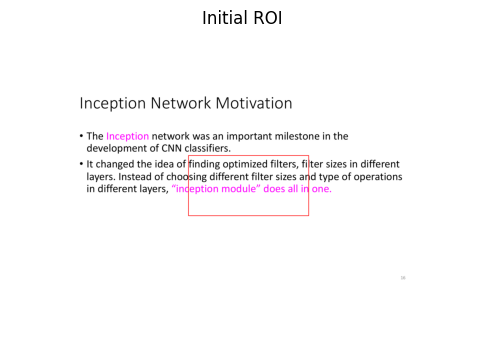


=== Expanding LEFT ===
  → ROI: [870, 620, 620, 300], Sim=0.5467
    Text snippet: 1 finding optimized filters, fil osing different filter size…
    ✔ New best: 0.5467
  → ROI: [850, 620, 640, 300], Sim=0.5515
    Text snippet: f finding optimized filters, fiL osing different filter size…
    ✔ New best: 0.5515
  → ROI: [830, 620, 660, 300], Sim=0.5592
    Text snippet: of finding optimized filters, fil oosing different filter si…
    ✔ New best: 0.5592
  → ROI: [810, 620, 680, 300], Sim=0.5621
    Text snippet: of finding optimized filters, fil hoosing different filter s…
    ✔ New best: 0.5621
  → ROI: [790, 620, 700, 300], Sim=0.2524
    Text snippet: a of finding optimized filters, fil choosing different filte…
  → ROI: [770, 620, 720, 300], Sim=0.2258
    Text snippet: ea of finding optimized filters, fil choosing different filt…
  → ROI: [750, 620, 740, 300], Sim=0.2461
    Text snippet: lea of finding optimized filters, fil f choosing different f…
  → ROI: [730, 620, 760, 300],

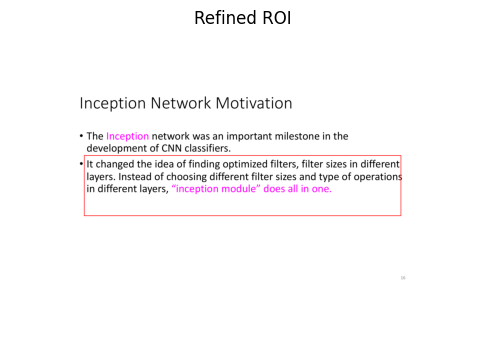


Final ROI on padded image: [370, 620, 1580, 300]
Final ROI on original image: [170, 420, 1580, 300]
Cropped region saved as: refined_crop.png


In [ ]:
# ----------------- PARAMETERS -----------------
RESIZE_STEP      = 20
ROI_WIDTH_MIN    = 60
ROI_HEIGHT_MIN   = 60
PADDING          = 200   # white border around image
MAX_NO_IMPROVE   = 20    # stop after 20 steps with sim < best
MAX_NO_CHANGE    = 10    # stop after 10 steps with sim == last

# ----------------- EASYOCR SETUP -----------------
reader = easyocr.Reader(['en'], gpu=True)

# ----------------- HELPERS -----------------
def get_cropped_image(image, roi):
    x, y, w, h = roi
    x0, y0 = max(0, x), max(0, y)
    x1     = min(x + w, image.shape[1])
    y1     = min(y + h, image.shape[0])
    return image[y0:y1, x0:x1]

def normalized_levenshtein_ratio(a, b):
    return SequenceMatcher(None, a.lower(), b.lower()).ratio()

def preprocess_image(img):
    gray      = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur      = cv2.GaussianBlur(gray, (3,3), 0)
    sharpened = cv2.addWeighted(gray, 1.5, blur, -0.5, 0)
    _, thresh = cv2.threshold(sharpened, 0, 255,
                              cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

def ocr_and_text(image, roi, target):
    crop = get_cropped_image(image, roi)
    prep = preprocess_image(crop)
    try:
        results = reader.readtext(prep)
    except Exception as e:
        print("OCR error:", e)
        return "", 0.0
    if not results:
        return "", 0.0
    text = " ".join([r[1] for r in results])
    sim  = normalized_levenshtein_ratio(text, target)
    return text, sim

def show_roi(img, roi, title="ROI"):
    disp = img.copy()
    x, y, w, h = roi
    cv2.rectangle(disp, (x,y), (x+w,y+h), (0,0,255), 2)
    plt.figure(figsize=(6,5))
    plt.imshow(cv2.cvtColor(disp, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# ----------------- ROI ADJUSTER -----------------
class ROIAdjuster:
    def __init__(self, image, roi, target, prev_sim):
        self.image    = image
        self.roi      = roi
        self.target   = target
        self.prev_sim = prev_sim

    def refine_roi(self):
        best_roi = self.roi
        best_sim = self.prev_sim

        for direction in ['left', 'right', 'up', 'down']:
            print(f"\n=== Expanding {direction.upper()} ===")
            current_roi = best_roi
            low_count   = 0
            same_count  = 0
            last_sim    = best_sim

            # try up to N expansions or until boundary
            for _ in range(200):
                x, y, w, h = current_roi
                if direction == 'left':
                    x -= RESIZE_STEP; w += RESIZE_STEP
                elif direction == 'right':
                    w += RESIZE_STEP
                elif direction == 'up':
                    y -= RESIZE_STEP; h += RESIZE_STEP
                else:  # down
                    h += RESIZE_STEP

                cand = [x, y, w, h]
                constrained = self.constrain_roi(cand)

                # stop if we hit the padded edge
                if constrained == current_roi:
                    print(f"— Hit {direction} boundary, stopping")
                    break

                current_roi = constrained
                text, sim = ocr_and_text(self.image, current_roi, self.target)

                print(f"  → ROI: {current_roi}, Sim={sim:.4f}")
                print(f"    Text snippet: {text[:60]}…")

                # update counts
                if sim > best_sim:
                    best_roi, best_sim = current_roi, sim
                    low_count  = 0
                    same_count = 0
                    last_sim   = sim
                    print(f"    ✔ New best: {best_sim:.4f}")
                elif sim < best_sim:
                    low_count += 1
                    same_count = 0
                else:  # sim == last_sim
                    same_count += 1

                # stop policies
                if low_count > MAX_NO_IMPROVE:
                    print(f"— Stopping {direction}: {low_count} low-sim steps")
                    break
                if same_count > MAX_NO_CHANGE:
                    print(f"— Stopping {direction}: {same_count} unchanged-sim steps")
                    break

            # end for expansions

        return best_roi

    def constrain_roi(self, roi):
        x, y, w, h = roi
        img_h, img_w = self.image.shape[:2]
        x = max(0, min(x, img_w - w))
        y = max(0, min(y, img_h - h))
        w = max(ROI_WIDTH_MIN, min(w, img_w - x))
        h = max(ROI_HEIGHT_MIN, min(h, img_h - y))
        return [x, y, w, h]

# ----------------- MAIN -----------------
orig = cv2.imread('week_09_page_017.png')
if orig is None:
    raise FileNotFoundError("Image not found.")
img = cv2.copyMakeBorder(orig, PADDING, PADDING, PADDING, PADDING,
                         cv2.BORDER_CONSTANT, value=[255,255,255])

target = (
    '• It changed the idea of finding optimized filters, '
    'filter sizes in different layers. Instead of choosing '
    'different filter sizes and type of operations in different layers, '
    '"inception module" does all in one.'
)
initial_roi = [690 + PADDING, 420 + PADDING, 600, 300]
_, start_sim = ocr_and_text(img, initial_roi, target)
print(f"Start similarity: {start_sim:.4f}")

show_roi(img, initial_roi, "Initial ROI")

adjuster = ROIAdjuster(img, initial_roi, target, start_sim)
final_roi = adjuster.refine_roi()

show_roi(img, final_roi, "Refined ROI")

# map back and save
x, y, w, h = final_roi
orig_roi = [x - PADDING, y - PADDING, w, h]
crop = get_cropped_image(orig, orig_roi)
cv2.imwrite('refined_crop.png', crop)
print("\nFinal ROI on padded image:", final_roi)
print("Final ROI on original image:", orig_roi)
print("Cropped region saved as: refined_crop.png")
